In [20]:
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from typing import Union,Sequence

import pandas as pd
from skimage.color import label2rgb
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import seaborn as sns
from atommic.collections.reconstruction.losses.haarpsi import haarpsi
import functools


In [21]:
# Function for plotting MRI scans



def get_scaled_image(
    x: Union[torch.Tensor, np.ndarray], percentile=0.99, clip=False
):
  """Scales image by intensity percentile (and optionally clips to [0, 1]).

  Args:
    x (torch.Tensor | np.ndarray): The image to process.
    percentile (float): The percentile of magnitude to scale by.
    clip (bool): If True, clip values between [0, 1]

  Returns:
    torch.Tensor | np.ndarray: The scaled image.
  """
  is_numpy = isinstance(x, np.ndarray)
  if is_numpy:
    x = torch.as_tensor(x)

  scale_factor = torch.quantile(x, percentile)
  x = x / scale_factor
  if clip:
    x = torch.clip(x, 0, 1)

  if is_numpy:
    x = x.numpy()

  return x


def plot_images(
    images, processor=None, disable_ticks=True, titles: Sequence[str]=None,
    ylabel: str=None, xlabels: Sequence[str]=None, cmap: str="gray",
    show_cbar: bool = False, overlay = None, opacity: float = 0.3,
    hsize=5, wsize=5, axs=None,fontsize =20
):
  """Plot multiple images in a single row.

  Add an overlay with the `overlay=` argument.
  Add a colorbar with `show_cbar=True`.
  """
  def get_default_values(x, default=""):
    if x is None:
      return [default] * len(images)
    return x

  titles = get_default_values(titles)
  ylabels = get_default_values(images)
  xlabels = get_default_values(xlabels)

  N = len(images)
  if axs is None:
    fig, axs = plt.subplots(1, N, figsize=(wsize * N, hsize))
  else:
    assert len(axs) >= N
    fig = axs.flatten()[0].get_figure()
  k = 0
  for ax, img, title, xlabel in zip(axs, images, titles, xlabels):
    if processor is not None:
      img = processor(img)
    if type(cmap)==list:
        im = ax.imshow(img, cmap=cmap[k])
        if type(show_cbar)==list:
            if show_cbar[k]:
                fig.subplots_adjust(bottom=0.2)
                cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.01])
                fig.colorbar(im, cax=cbar_ax)
    else:
      im = ax.imshow(img, cmap=cmap)
    k = k+1
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel(xlabel)


  if type(overlay) ==list:
    for i,ax in enumerate(axs.flatten()):
      if overlay[i] is not None:
        im = ax.imshow(overlay[i], alpha=opacity)


  if disable_ticks:
    for ax in axs.flatten():
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])

  return axs


In [22]:
# Function for transforming segmentation classes into categorical
def one_hot_to_categorical(x, channel_dim: int = 1, background=False):
    """Converts one-hot encoded predictions to categorical predictions.

    Args:
        x (torch.Tensor | np.ndarray): One-hot encoded predictions.
        channel_dim (int, optional): Channel dimension.
            Defaults to ``1`` (i.e. ``(B,C,...)``).
        background (bool, optional): If ``True``, assumes index 0 in the
            channel dimension is the background.

    Returns:
        torch.Tensor | np.ndarray: Categorical array or tensor. If ``background=False``,
        the output will be 1-indexed such that ``0`` corresponds to the background.
    """
    is_ndarray = isinstance(x, np.ndarray)
    if is_ndarray:
        x = torch.as_tensor(x)

    if background is not None and background is not False:
        out = torch.argmax(x, channel_dim)
    else:
        out = torch.argmax(x.type(torch.long), dim=channel_dim) + 1
        out = torch.where(x.sum(channel_dim) == 0, torch.tensor([0], device=x.device), out)

    if is_ndarray:
        out = out.numpy()
    return out

In [23]:
def haarpsi3d(x: np.ndarray, y: np.ndarray, seg: np.ndarray = np.array([]),maxval: np.ndarray = None) -> float:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if seg.ndim == 2:
        seg = seg[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match pred.")
    reduction = 'mean'
    scales = 3
    subsample = True
    c = 30.0
    alpha = 4.2

    maxval = np.max(x) if maxval is None else maxval
    _haarpsi = functools.partial(haarpsi, scales=scales, subsample=subsample, c=c, alpha=alpha,
                                 data_range=maxval, reduction=reduction)
    if np.size(seg)==0:
        __haarpsi = sum(
            _haarpsi(torch.from_numpy(x[slice_num]).unsqueeze(0).float(),
                     torch.from_numpy(y[slice_num]).unsqueeze(0).float()) for slice_num in
            range(x.shape[0])
        ).numpy()
    else:
        __haarpsi = []
        for slice_num in range(x.shape[0]):
            x_seg = x[slice_num]*seg[slice_num]
            y_seg = y[slice_num]*seg[slice_num]
            non_zero_coord = np.column_stack(np.where(x_seg>0))
            if np.size(non_zero_coord) >0:
                min_x, min_y = np.min(non_zero_coord,axis = 0)
                max_x, max_y = np.max(non_zero_coord,axis = 0)
                y_seg = y_seg[min_x:max_x,min_y:max_y]
                x_seg = x_seg[min_x:max_x,min_y:max_y]
                max_val = max(np.max(x_seg),np.max(y_seg))
                functools.partial(haarpsi, scales=scales, subsample=subsample, c=c, alpha=alpha,
                                 data_range=maxval, reduction=reduction)
                __haarpsi.append(_haarpsi(torch.from_numpy(x_seg).unsqueeze(0).float(),
                     torch.from_numpy(y_seg).unsqueeze(0).float()))
        __haarpsi=sum(__haarpsi)

    return __haarpsi / x.shape[0]

In [24]:
def ssim(x: np.ndarray, y: np.ndarray, seg: np.ndarray = np.array([]),maxval: np.ndarray = None) -> float:
    """Computes Structural Similarity Index Measure (SSIM).

    Parameters
    ----------
    x : np.ndarray
        Target image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D images,
        the first dimension should be 1.
    y : np.ndarray
        Predicted image. It must be a 3D array, where the first dimension is the number of slices. In case of 2D
        images, the first dimension should be 1.
    maxval : np.ndarray
        Maximum value of the images. If None, it is computed from the images. If the images are normalized, maxval
        should be 1.

    Returns
    -------
    float
        Structural Similarity Index Measure.

    Examples
    --------
    >>> from atommic.collections.reconstruction.metrics.reconstruction_metrics import ssim
    >>> import numpy as np
    >>> datax = np.random.rand(3, 100, 100)
    >>> datay = datax * 0.5
    >>> ssim(datax, datay)
    0.01833040155119426

    .. note::
        x and y must be normalized to the same range, e.g. [0, 1].

        The SSIM is computed using the scikit-image implementation of the SSIM metric.
        Source: https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.structural_similarity
    """
    if x.ndim == 2:
        x = x[np.newaxis, :, :]
    if y.ndim == 2:
        y = y[np.newaxis, :, :]
    if seg.ndim == 2:
        seg = seg[np.newaxis, :, :]
    if x.ndim != 3:
        raise ValueError("Unexpected number of dimensions in ground truth.")
    if x.ndim != y.ndim:
        raise ValueError("Ground truth dimensions does not match prediction dimensions.")

    maxval = max(np.max(x) - np.min(x), np.max(y) - np.min(y)) if maxval is None else maxval
    maxval = max(maxval, 1)
    if np.size(seg)==0:
        ssim_score = sum(
        structural_similarity(x[slice_num], y[slice_num], data_range=maxval) for slice_num in range(x.shape[0])
    )
    else:
        ssim_score = []
        for slice_num in range(x.shape[0]):
            x_seg = x[slice_num]*seg[slice_num]
            y_seg = y[slice_num]*seg[slice_num]
            non_zero_coord = np.column_stack(np.where(x_seg>0))
            if np.size(non_zero_coord) >0:
                min_x, min_y = np.min(non_zero_coord,axis = 0)
                max_x, max_y = np.max(non_zero_coord,axis = 0)
                y_seg = y_seg[min_x:max_x,min_y:max_y]
                x_seg = x_seg[min_x:max_x,min_y:max_y]
                ssim_score.append(structural_similarity(x_seg, y_seg, data_range=maxval))
        ssim_score = sum(ssim_score)
    return ssim_score / x.shape[0]

In [25]:
def complex_abs(x: torch.Tensor) -> torch.Tensor:
    """
    Compute the absolute value of a complex valued input tensor.

    Parameters
    ----------
    x : torch.Tensor
        Complex tensor. The last dimension must be of size 2.

    Returns
    -------
    torch.Tensor
        Absolute value of complex tensor.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import complex_abs
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> complex_abs(data)
    tensor([1.4142, 2.8284, 4.2426])
    """
    if x.shape[-1] != 2:
        if torch.is_complex(x):
            x = torch.view_as_real(x)
        else:
            raise ValueError("Tensor does not have separate complex dim.")
    return (x**2).sum(dim=-1)

In [26]:
def check_stacked_complex(x: torch.Tensor) -> torch.Tensor:
    """
    Check if tensor is stacked complex (real & imaginary parts stacked along last dim) and convert it to a combined
    complex tensor.

    Parameters
    ----------
    x : torch.Tensor
        Tensor to check.

    Returns
    -------
    torch.Tensor
        Tensor with stacked complex converted to combined complex.

    Examples
    --------
    >>> from atommic.collections.common.parts.utils import check_stacked_complex
    >>> import torch
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> data = torch.view_as_real(data)
    >>> data.shape
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    >>> data = torch.tensor([1+1j, 2+2j, 3+3j])
    >>> data.shape
    torch.Size([3])
    >>> check_stacked_complex(data)
    tensor([1.+1.j, 2.+2.j, 3.+3.j])
    >>> check_stacked_complex(data).shape
    torch.Size([3])
    """
    return torch.view_as_complex(x) if x.shape[-1] == 2 else x

In [70]:

fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/2024-02-23_10-50-54/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_1 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_1 = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()

fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/2024-02-23_10-48-49/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs_1 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_1 = f['segmentation'][()].squeeze()
    target_mtlrs_1 = f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_1 = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_1 = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_1 = f['zero_filled'][()].squeeze()


fname = '/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/2024-02-21_16-18-15/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    scan_mtlrs_2 = f['reconstruction'][()].squeeze()
    prediction_mtlrs_2 = f['segmentation'][()].squeeze()
    target_mtlrs_2= f['target_reconstruction'][()].squeeze()
    segmentation_labels_mtlrs_2 = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs_2 = f['uncertainty'][()].squeeze()
    zero_filled_mtlrs_2 = f['zero_filled'][()].squeeze()

print(np.unique(zero_filled_mtlrs_1.reshape(1,-1)-zero_filled_mtlrs_2.reshape(1,-1)))
print(np.unique(target_mtlrs_1.reshape(1,-1)-target_mtlrs_2.reshape(1,-1)))

<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>
<KeysViewHDF5 ['intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'uncertainty', 'zero_filled']>
[0.+0.j]
[0.+0.j]


MTLRS_NO_MTL_MCE stacked SSIM : 0.8118738490343094
MTLRS_MTL_MCE stacked SSIM : 0.8462372726680029
zero filled stacked SSIM : 0.5040671029475329
MTLRS_MTL_MCE  stacked HaarPSI : 0.6622086763381958
MTLRS_MTL_BCE stacked HaarPSI : 0.7747980356216431
zero filled stacked HaarPSI : 0.44515112042427063
[0.12413548 0.12442753 0.12452283 ... 0.39718217 0.39722225 0.39751765]


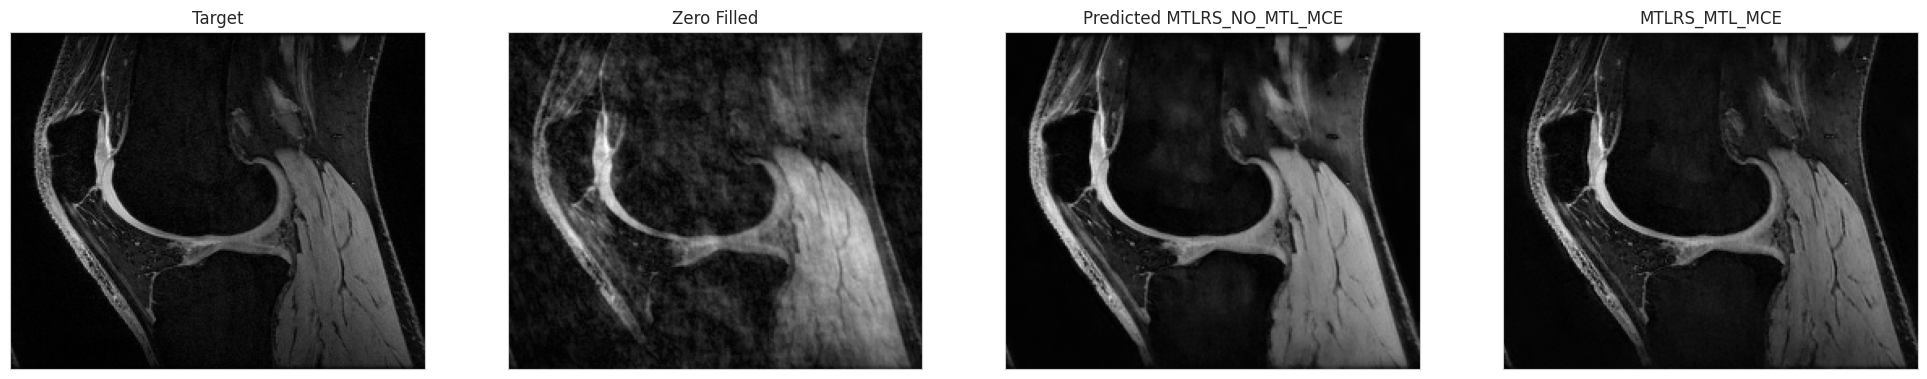

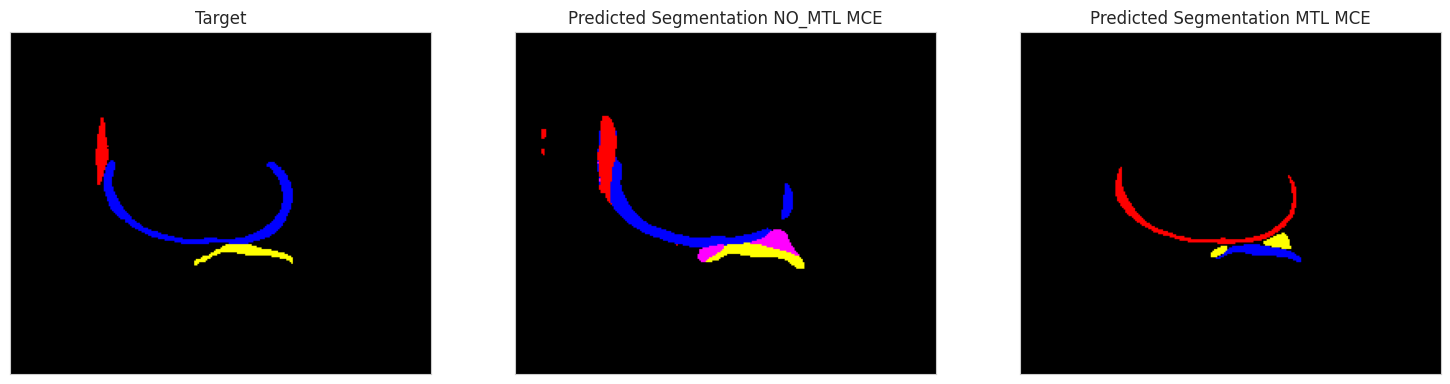

In [71]:
sl = 10
output ='stacked'

if output == 'complex_abs':
    scan_output_1 = scan_mtlrs_1[sl]**2
    target_output = target_mtlrs_1[sl]**2
    scan_output_2 = scan_mtlrs_2[sl]**2
    zero_filled_output = zero_filled_mtlrs_1[sl]**2
if output == 'complex_abs_sqrt':
    scan_output_1 = np.sqrt(scan_mtlrs_1[sl]**2)
    target_output = np.sqrt(target_mtlrs_1[sl]**2)
    scan_output_2 = np.sqrt(scan_mtlrs_2[sl]**2)
    zero_filled_output = np.sqrt(zero_filled_mtlrs_1[sl]**2)
if output == 'stacked':
    scan_output_1 = scan_mtlrs_1[sl]
    target_output = target_mtlrs_1[sl]
    scan_output_2 = scan_mtlrs_2[sl]
    zero_filled_output = zero_filled_mtlrs_1[sl]
scan_output_1_norm = np.abs(scan_output_1/np.max(np.abs(scan_output_1))).real.astype(np.float32)
target_norm = np.abs(target_output/np.max(np.abs(target_output))).real.astype(np.float32)
scan_output_2_norm = np.abs(scan_output_2 /np.max(np.abs(scan_output_2 ))).real.astype(np.float32)
zero_filled_norm = np.abs(zero_filled_output/np.max(np.abs(zero_filled_output))).real.astype(np.float32)


max_value = max(np.max(scan_output_1_norm)-np.min(scan_output_1_norm), np.max(target_norm)-np.min(target_norm))
SSIM_mtlrs = ssim(target_norm,scan_output_1_norm,maxval=max_value)

max_value = max(np.max(scan_output_1_norm), np.max(target_norm))
HaarPSI_mtlrs = haarpsi3d(target_norm,scan_output_1_norm,maxval=max_value)

max_value = max(np.max(scan_output_2_norm)-np.min(scan_output_2_norm), np.max(target_norm)-np.min(target_norm))
SSIM_cirim = ssim(target_norm,scan_output_2_norm,maxval=max_value)

max_value = max(np.max(scan_output_2_norm), np.max(target_norm))
HaarPSI_cirim = haarpsi3d(target_norm,scan_output_2_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm)-np.min(zero_filled_norm), np.max(target_norm)-np.min(target_norm))
SSIM_zero= ssim(target_norm,zero_filled_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm), np.max(target_norm))
HaarPSI_zero= haarpsi3d(target_norm,zero_filled_norm,maxval=max_value)

hsize = 5
wsize = hsize / scan_output_1_norm.shape[0] * scan_output_1_norm.shape[1]
print(f"MTLRS_NO_MTL_MCE {output} SSIM : {SSIM_mtlrs}")
print(f"MTLRS_MTL_MCE {output} SSIM : {SSIM_cirim}")
print(f"zero filled {output} SSIM : {SSIM_zero}")
print(f"MTLRS_MTL_MCE  {output} HaarPSI : {HaarPSI_mtlrs}")
print(f"MTLRS_MTL_BCE {output} HaarPSI : {HaarPSI_cirim}")
print(f"zero filled {output} HaarPSI : {HaarPSI_zero}")

plot_images([target_norm, zero_filled_norm,scan_output_1_norm,scan_output_2_norm], titles=['Target', 'Zero Filled', "Predicted MTLRS_NO_MTL_MCE","MTLRS_MTL_MCE"], fontsize=12, wsize=wsize, hsize=hsize,cmap=['gray','gray','gray','gray'])
plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_reconstruction_gaussian2d_3_mtls.png')

pred_seg_1 = label2rgb(np.argmax(prediction_mtlrs_1[sl, :, :, :],axis=0), bg_label=0)
print(np.unique(prediction_mtlrs_1.reshape(-1,1)))
#pred_seg_2 = label2rgb(one_hot_to_categorical(prediction_mtlrs_2[sl, :, :, :], channel_dim=0), bg_label=0)
pred_seg_2 = label2rgb(np.argmax(prediction_mtlrs_2[sl, :, :, :],axis=0), bg_label=0)
tar_seg = label2rgb(np.argmax(segmentation_labels_mtlrs_1[sl, :, :, :],axis=0), bg_label=0)
plot_images([tar_seg, pred_seg_1,pred_seg_2], titles=['Target', "Predicted Segmentation NO_MTL MCE","Predicted Segmentation MTL MCE"], fontsize=12, wsize=wsize, hsize=hsize)
plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_segmentation_MCE_BCE_gaussian2d_4x.png')


[atommic W 2024-02-26 13:00:35 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
      return math.isfinite(val)
    
[atommic W 2024-02-26 13:00:35 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
      return arr.astype(dtype, copy=True)
    
[atommic W 2024-02-26 13:00:35 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
      return math.isfinite(val)
    
[atommic W 2024-02-26 13:00:35 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
   

(39, 2, 5, 208, 256)


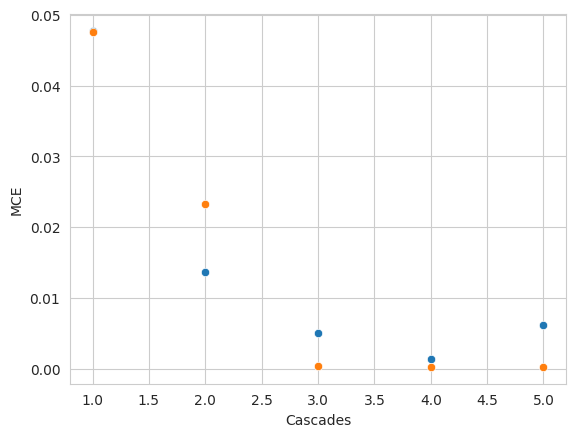

In [72]:
print(uncertainty_mtlrs_1.shape)
MTLRS_1_mean = [np.mean(uncertainty_mtlrs_1[sl,1,i].reshape(1,-1)) for i in range(uncertainty_mtlrs_1.shape[2])]
MTLRS_2_mean = [np.mean(uncertainty_mtlrs_2[sl,1,i].reshape(1,-1)) for i in range(uncertainty_mtlrs_2.shape[2])]

data_frame = pd.DataFrame({'MCE':MTLRS_1_mean,'BCE':MTLRS_2_mean,'Cascades':[1,2,3,4,5]})
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MCE,legend=True)
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.BCE,legend= True)
plt.savefig('/scratch/tmpaquaij/Figures/Max_variance_per_cascade_poisson2d_4x.png')


In [66]:
sl = 20
output ='stacked'

if output == 'complex_abs':
    scan_mtlrs_output = scan_mtlrs[sl]**2
    target_output = target[sl]**2
    scan_cirim_output = scan_cirim[sl]**2
    zero_filled_output = zero_filled[sl]**2
if output == 'complex_abs_sqrt':
    scan_mtlrs_output = np.sqrt(scan_mtlrs[sl]**2)
    target_output = np.sqrt(target[sl]**2)
    zero_filled_output = np.sqrt(zero_filled[sl]**2)
    scan_cirim_output = np.sqrt(scan_cirim[sl]**2)
if output == 'stacked':
    scan_mtlrs_output = scan_mtlrs[sl]
    target_output = target[sl]
    zero_filled_output = zero_filled[sl]
    scan_cirim_output = scan_cirim[sl]
scan_mtlrs_norm = np.abs(scan_mtlrs_output/np.max(np.abs(scan_mtlrs_output))).real.astype(np.float32)
target_norm = np.abs(target_output/np.max(np.abs(target_output))).real.astype(np.float32)
scan_cirim_norm = np.abs(scan_cirim_output/np.max(np.abs(scan_cirim_output))).real.astype(np.float32)
zero_filled_norm = np.abs(zero_filled_output/np.max(np.abs(zero_filled_output))).real.astype(np.float32)

#Select only segmented area:
non_zero_coord = np.column_stack(np.where(target_norm*segmentation_labels[sl]>0))
min_x, min_y = np.min(non_zero_coord,axis = 0)
max_x, max_y = np.max(non_zero_coord,axis = 0)

scan_mtlrs_norm = scan_mtlrs_norm[min_x:max_x,min_y:max_y]
target_norm = target_norm[min_x:max_x,min_y:max_y]
scan_cirim_norm = scan_cirim_norm[min_x:max_x,min_y:max_y]
zero_filled_norm = zero_filled_norm[min_x:max_x,min_y:max_y]

max_value = max(np.max(scan_mtlrs_norm)-np.min(scan_mtlrs_norm), np.max(target_norm)-np.min(target_norm))
SSIM_mtlrs = ssim(target_norm,scan_mtlrs_norm,maxval=max_value)

max_value = max(np.max(scan_mtlrs_norm), np.max(target_norm))
HaarPSI_mtlrs = haarpsi3d(target_norm,scan_mtlrs_norm,maxval=max_value)

max_value = max(np.max(scan_cirim_norm)-np.min(scan_cirim_norm), np.max(target_norm)-np.min(target_norm))
SSIM_cirim = ssim(target_norm,scan_cirim_norm,maxval=max_value)

max_value = max(np.max(scan_cirim_norm), np.max(target_norm))
HaarPSI_cirim = haarpsi3d(target_norm,scan_cirim_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm)-np.min(zero_filled_norm), np.max(target_norm)-np.min(target_norm))
SSIM_zero= ssim(target_norm,zero_filled_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm), np.max(target_norm))
HaarPSI_zero= haarpsi3d(target_norm,zero_filled_norm,maxval=max_value)

hsize = 5
wsize = hsize / scan_mtlrs_norm.shape[0] * scan_mtlrs_norm.shape[1]
print(f"MTLRS {output} SSIM : {SSIM_mtlrs}")
print(f"CIRIM {output} SSIM : {SSIM_cirim}")
print(f"zero filled {output} SSIM : {SSIM_zero}")
print(f"MTLRS {output} HaarPSI : {HaarPSI_mtlrs}")
print(f"CIRIM {output} HaarPSI : {HaarPSI_cirim}")
print(f"zero filled {output} HaarPSI : {HaarPSI_zero}")

plot_images([target_norm, zero_filled_norm,scan_mtlrs_norm,scan_cirim_norm], titles=['Target', 'Zero Filled', "Predicted (MTLRS)","Predicted (CIRIM)"], fontsize=12, wsize=wsize, hsize=hsize,cmap=['gray','gray','gray','gray'])
plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_reconstruction_gaussian2d_8.png')




NameError: name 'scan_mtlrs' is not defined

In [ ]:
segmentation_labels = segmentation_labels_org
pred_seg = label2rgb(one_hot_to_categorical(predictions[sl, :, :, :], channel_dim=0), bg_label=0)
tar_seg = label2rgb(one_hot_to_categorical(segmentation_labels[sl, :, :, :], channel_dim=0), bg_label=0)
plot_images([tar_seg, pred_seg], titles=['Target', "predicted Segmentation"], fontsize=12, wsize=wsize, hsize=hsize)
plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_segmentation_gaussian2d_8.png')

In [ ]:
hsize = 9
wsize = hsize / scan_mtlrs_norm.shape[0] * scan_mtlrs_norm.shape[1]

_, axs = plt.subplots(2, uncertainty_mtlrs.shape[1], figsize=(uncertainty_mtlrs.shape[1] * wsize, 2 * hsize))
mtlrs = [uncertainty_mtlrs[sl,i] for i in range(uncertainty_mtlrs.shape[1])]
cirim = [uncertainty_cirim[sl,i] for i in range(uncertainty_mtlrs.shape[1])]
titles = [f"Variance_logliklihood_gradient Cascade:{idx+1}" for idx in range(uncertainty_mtlrs.shape[1])]
plot_images(mtlrs, titles=titles, fontsize=25, wsize=wsize, hsize=hsize,cmap=['viridis','viridis','viridis','viridis','viridis'],axs=axs[0])
axs[0][0].set_ylabel("MTLRS", fontsize=20)
plot_images(cirim,wsize=wsize, hsize=hsize,cmap=['viridis','viridis','viridis','viridis','viridis'],axs=axs[1])
axs[1][0].set_ylabel("CIRIM", fontsize=20)
plt.savefig('/scratch/tmpaquaij/Figures/Variance_per_cascade_gaussian2d_8x.png')








In [ ]:
MTLRS_max = [np.mean(np.sqrt(uncertainty_mtlrs[sl,i].reshape(1,-1))) for i in range(uncertainty_mtlrs.shape[1])]
CIRIM_max = [np.mean(np.sqrt(uncertainty_cirim[sl,i].reshape(1,-1))) for i in range(uncertainty_cirim.shape[1])]

data_frame = pd.DataFrame({'CIRIM':CIRIM_max,'MTLRS':MTLRS_max,'Cascades':[1,2,3,4,5]})
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS,label="MTLRS")
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM,label="CIRIM")
plt.savefig('/scratch/tmpaquaij/Figures/Max_variance_per_cascade_gaussian2d_8x.png')
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation of each time step loglikelihood gradient per cascade")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
fname = '/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_4x/2024-01-15_17-43-55/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_mtlrs = f['reconstruction'][()].squeeze()
    predictions = f['segmentation'][()].squeeze()
    target_mtlrs = f['target_reconstruction'][()].squeeze()
    segmentation_labels = f['target_segmentation'][()].squeeze()
    uncertainty_mtlrs = f['uncertainty'][()].squeeze()
    zero_filled = f['zero_filled'][()].squeeze()
print(scan_mtlrs.shape,predictions.shape,segmentation_labels.shape,target_mtlrs.shape, uncertainty_mtlrs.shape)

fname = '/scratch/tmpaquaij/Results/atommic/mltrs/trained_models/SKMTEA/CIRIM_sense/predictions_4x/2024-01-15_21-52-00/predictions/MTR_005.h5'
with h5py.File(fname, "r") as f:
    print(f.keys())
    scan_cirim = f['reconstruction'][()].squeeze()
    target_cirim  = f['target_reconstruction'][()].squeeze()
    uncertainty_cirim  = f['uncertainty'][()].squeeze()
#segmentation_labels = nib.load(fsegname).get_fdata()
print(scan_cirim.shape,target_cirim.shape, uncertainty_cirim.shape)

In [ ]:
predictions = np.abs(predictions.astype(np.float32))
predictions = np.where(predictions > 0.5, 1, 0)

segmentation_labels = np.abs(segmentation_labels.astype(np.float32))
segmentation_labels = np.where(segmentation_labels > 0.5, 1, 0)

print(predictions.shape,segmentation_labels.shape)

In [ ]:
sl = 49
output ='stacked'

if output == 'complex_abs':
    scan_mtlrs_output = scan_mtlrs[sl]**2
    target_mtlrs_output = target_mtlrs[sl]**2
    scan_cirim_output = scan_cirim[sl]**2
    target_cirim_output = target_cirim[sl]**2
    zero_filled_output = zero_filled[sl]**2
if output == 'complex_abs_sqrt':
    scan_mtlrs_output = np.sqrt(scan_mtlrs[sl]**2)
    target_mtlrs_output = np.sqrt(target_mtlrs[sl]**2)
    zero_filled_output = np.sqrt(zero_filled[sl]**2)
    scan_cirim_output = np.sqrt(scan_cirim[sl]**2)
    target_cirim_output = np.sqrt(target_cirim[sl]**2)
if output == 'stacked':
    scan_mtlrs_output = scan_mtlrs[sl]
    target_mtlrs_output = target_mtlrs[sl]
    zero_filled_output = zero_filled[sl]
    scan_cirim_output = scan_cirim[sl]
    target_cirim_output = target_cirim[sl]
scan_mtlrs_norm = np.abs(scan_mtlrs_output/np.max(np.abs(scan_mtlrs_output))).real.astype(np.float32)
target_mtlrs_norm = np.abs(target_mtlrs_output/np.max(np.abs(target_mtlrs_output))).real.astype(np.float32)
scan_cirim_norm = np.abs(scan_cirim_output/np.max(np.abs(scan_cirim_output))).real.astype(np.float32)
target_cirim_norm = np.abs(target_cirim_output/np.max(np.abs(target_cirim_output))).real.astype(np.float32)
zero_filled_norm = np.abs(zero_filled_output/np.max(np.abs(zero_filled_output))).real.astype(np.float32)

max_value = max(np.max(scan_mtlrs_norm)-np.min(scan_mtlrs_norm), np.max(target_mtlrs_norm)-np.min(target_mtlrs_norm))
score_mtlrs = ssim(target_mtlrs_norm,scan_mtlrs_norm,maxval=max_value)

max_value = max(np.max(scan_cirim_norm)-np.min(scan_cirim_norm), np.max(target_cirim_norm)-np.min(target_cirim_norm))
score_cirim = ssim(target_cirim_norm,scan_cirim_norm,maxval=max_value)

max_value = max(np.max(zero_filled_norm)-np.min(zero_filled_norm), np.max(target_cirim_norm)-np.min(target_cirim_norm))
score_zero= ssim(target_cirim_norm,zero_filled_norm,maxval=max_value)

hsize = 5
wsize = hsize / scan_mtlrs_norm.shape[0] * scan_mtlrs_norm.shape[1]
print(f"MTLRS {output} SSIM : {score_mtlrs}")
print(f"CIRIM {output} SSIM : {score_cirim}")
print(f"zero filled {output} SSIM : {score_zero}")

plot_images([target_mtlrs_norm, zero_filled_norm,scan_mtlrs_norm,scan_cirim_norm], titles=['Target', 'Zero Filled', "Predicted (MTLRS)","Predicted (CIRIM)"], fontsize=12, wsize=wsize, hsize=hsize,cmap=['gray','gray','gray','gray'])
plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_reconstruction_poisson2d_4.png')

In [ ]:
plot_images([tar_seg, pred_seg], titles=['Target', "predicted Segmentation"], fontsize=12, wsize=wsize, hsize=hsize)
plt.savefig('/scratch/tmpaquaij/Figures/Accelerated_segmentation_poisson2d_4.png')

In [ ]:
hsize = 9
wsize = hsize / scan_mtlrs_norm.shape[0] * scan_mtlrs_norm.shape[1]

_, axs = plt.subplots(2, uncertainty_mtlrs.shape[1], figsize=(uncertainty_mtlrs.shape[1] * wsize, 2 * hsize))
mtlrs = [uncertainty_mtlrs[sl,i] for i in range(uncertainty_mtlrs.shape[1])]
cirim = [uncertainty_cirim[sl,i] for i in range(uncertainty_mtlrs.shape[1])]
titles = [f"Variance_logliklihood_gradient Cascade:{idx+1}" for idx in range(uncertainty_mtlrs.shape[1])]
plot_images(mtlrs, titles=titles, fontsize=25, wsize=wsize, hsize=hsize,cmap=['viridis','viridis','viridis','viridis','viridis'],axs=axs[0])
axs[0][0].set_ylabel("MTLRS", fontsize=20)
plot_images(cirim,wsize=wsize, hsize=hsize,cmap=['viridis','viridis','viridis','viridis','viridis'],axs=axs[1])
axs[1][0].set_ylabel("CIRIM", fontsize=20)
plt.savefig('/scratch/tmpaquaij/Figures/Variance_per_cascade_poisson_4x.png')

In [ ]:
MTLRS_max = [np.max(uncertainty_mtlrs[sl,i].reshape(1,-1)) for i in range(uncertainty_mtlrs.shape[1])]
CIRIM_max = [np.max(uncertainty_cirim[sl,i].reshape(1,-1)) for i in range(uncertainty_cirim.shape[1])]

data_frame = pd.DataFrame({'CIRIM':CIRIM_max,'MTLRS':MTLRS_max,'Cascades':[1,2,3,4,5]})
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.MTLRS)
sns.scatterplot(data=data_frame,x=data_frame.Cascades,y=data_frame.CIRIM)
plt.savefig('/scratch/tmpaquaij/Figures/Max_variance_per_cascade_poisson2d_4x.png')

In [ ]:
import torch
loss_cascades = []
weigths_cascades = torch.logspace(-1,0,steps = 5)
print(weigths_cascades,'Cascade Weights')
for i in range(5):
    weigths_inter = torch.logspace(-1,0,steps = 8)
    print(weigths_inter, 'Weights Intermediate Predictions')
    loss_inter = [abs(torch.randn(1))/2 for _ in range(8)]
    print(loss_inter,"Intermediate losses")
    loss_cascade = sum(x * w for x, w in zip(loss_inter, weigths_inter)) / len(weigths_inter)
    loss_cascades.append(loss_cascade)
print(loss_cascades,'Cascades Losses')
total_loss = sum(x * w for x, w in zip(loss_cascades, weigths_cascades)) / len(weigths_cascades)
print(total_loss,"Average Loss")
